# Data
Download the IMDB reviews if its not already in the local cache.
Load from the local cache and split to train and test sets.

In [1]:
import os
import ssl
from keras.utils import get_file
try:
    from notebooks.data import load_imdb
except ModuleNotFoundError:
    from data import load_imdb

if (not os.environ.get('PYTHONHTTPSVERIFY', '')
        and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

zip_file = get_file('aclImdb.zip', origin='http://mng.bz/0tIo', extract=True)
imdb_dir = zip_file.replace('.zip', '')
(train_texts, train_labels), (test_texts, test_labels) = load_imdb(imdb_dir)

print('An example from the reviews:')
print('============================')
print(f'Text : {train_texts[0][:200]}...')
print(f'Label: {train_labels[0]}')

Using TensorFlow backend.


An example from the reviews:
Text : If you are expecting to see a lot in the bath of Alt&#305;oklar, as it is promised by the tag line, you will be very disappointed to see that the movie consists of nothing but the populist style of Al...
Label: neg


# Prepare Data
Initialize a `CharVectorizer`. The vectorizer will be fitted on the 
`train_texts`. We won't use any word tokenizer, so the words will be splitted
on spaces. The vocabulary will have only the characters set on the 
`characters` attribute, the PAD and the OOV token.

In [2]:
from keras_nlp import CharVectorizer

char_vectorizer = CharVectorizer(
    characters='abcdefghijklmnopqrstuvwxyz', oov_token='#')
char_vectorizer.fit_on_texts(train_texts)
# The vectorizer's number of tokens: num_chars + PAD + OOV token
print(f'Vectorizer number of tokens: {len(char_vectorizer.token2id)}')

19-Dec-06 23:15:11 [INFO    ] [CharVectorizer] - Creating vocabulary.


Vectorizer number of tokens: 28


## Vectorize Data
We apply the fitted vectorizer onto the train and test texts. 
We keep `max_tokens` per text and `max_characters` per token.

In [3]:
max_tokens, max_characters = 1000, 10
X_train = char_vectorizer.texts_to_vectors(
    train_texts, shape=(max_tokens, max_characters))

19-Dec-06 23:15:38 [INFO    ] [CharVectorizer] - Converting texts to vectors.
19-Dec-06 23:15:49 [INFO    ] [CharVectorizer] - Reshaping vectors to shape (1000, 10).


25000/25000 [==============================] - 24s 967us/step

**Attention**: We *must* pass the same shape `(max_tokens, max_characters)` 
when converting different text sets. If we don't, then it is almost certain 
that the results will have different numbers of columns because the sets are 
likely to have different number of tokens.

In [4]:
X_test = char_vectorizer.texts_to_vectors(
    test_texts, shape=(max_tokens, max_characters))

19-Dec-06 23:16:26 [INFO    ] [CharVectorizer] - Converting texts to vectors.
19-Dec-06 23:16:37 [INFO    ] [CharVectorizer] - Reshaping vectors to shape (1000, 10).


25000/25000 [==============================] - 23s 912us/step

## Decode Data
We print a decoded fragment of a encoded text as an example.

In [5]:
decoded = char_vectorizer.vectors_to_texts(X_test[:1])
print('Example fragment of decoded review')
print('==================================')
print(decoded[0][67:76])

19-Dec-06 23:17:21 [INFO    ] [CharVectorizer] - Converting vectors to texts.


1/1 [==============================] - 0s 3ms/step
Example fragment of decoded review
[['s', 'e', 'e', 'm', 's'], ['t', 'o'], ['b', 'e'], ['a'], ['v', 'e', 'r', 'y'], ['i', 's', 'i', 'o', 'n', 'i', 's', 't', 'i', 'c'], ['v', 'i', 'e', 'w'], ['o', 'f'], ['h', 'i', 's', 't', 'o', 'r', 'y']]


## Encode Labels
The labels are strings ('pos' / 'neg'). We will convert them to numbers.

In [6]:
from sklearn.preprocessing import label_binarize

y_train = label_binarize(train_labels, classes=['neg', 'pos'])
y_test = label_binarize(test_labels, classes=['neg', 'pos'])

## Keep a Validation Set

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, stratify=y_train, shuffle=True, random_state=44)

print(f'X_train: {X_train.shape}')
print(f'X_dev  : {X_val.shape}')
print(f'X_test : {X_test.shape}')

X_train: (18750, 1000, 10)
X_dev  : (6250, 1000, 10)
X_test : (25000, 1000, 10)


# Neural Network
Here we define a toy network for demonstration purpose.

In [8]:
from keras.models import Model
from keras.layers import (Input, TimeDistributed, Embedding, Flatten, Dense,
                          Dropout)

chars_input = Input(
    shape=(
        max_tokens,
        max_characters,
    ), name='Input', dtype='int32')
chars_embeddings = TimeDistributed(
    Embedding(
        input_dim=char_vectorizer.num_tokens,
        output_dim=20,
        input_length=max_characters,
        mask_zero=False,
        trainable=True),
    name='Embeddings')(chars_input)
x = Dropout(0.4, name='Input_Dropout')(chars_embeddings)
x = Flatten(name='Flatten')(x)
x = Dropout(0.4, name='Dropout')(x)
predictions = Dense(1, activation='sigmoid', name='Predictions')(x)
model = Model(chars_input, predictions)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 1000, 10)          0         
_________________________________________________________________
Embeddings (TimeDistributed) (None, 1000, 10, 20)      560       
_________________________________________________________________
Input_Dropout (Dropout)      (None, 1000, 10, 20)      0         
_________________________________________________________________
Flatten (Flatten)            (None, 200000)            0         
_________________________________________________________________
Dropout (Dropout)            (None, 200000)            0         
_________________________________________________________________
Predictions (Dense)          (None, 1)                 200001    
Total params: 200,561
Trainable params: 200,561
Non-trainable params: 0
_________________________________________________________________
None

## Train Model

In [9]:
model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(
    X_train, y_train, batch_size=50, epochs=5, validation_data=(X_val, y_val))

Train on 18750 samples, validate on 6250 samples
Epoch 1/5
18750/18750 [==============================] - 12s 645us/step - loss: 0.6874 - acc: 0.5464 - val_loss: 0.6628 - val_acc: 0.6163

## Model Evaluation

In [10]:
scores = model.evaluate(X_test, y_test)
print(f'Evaluation accuracy: {100*scores[1]:.2f}%')

25000/25000 [==============================] - 3s 134us/step

## Plot Accuracy and Loss

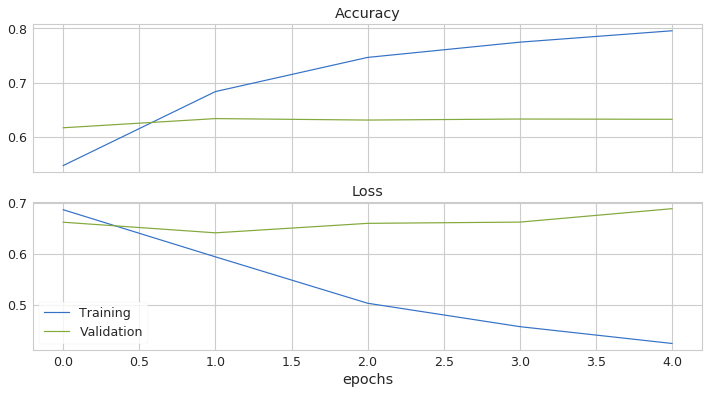

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 6))
ax1.plot(history.epoch, history.history['acc'], label='Training')
ax1.plot(history.epoch, history.history['val_acc'], label='Validation')
ax1.set_title('Accuracy')

ax2.plot(history.epoch, history.history['loss'], label='Training')
ax2.plot(history.epoch, history.history['val_loss'], label='Validation')
ax2.set_title('Loss')
ax2.set_xlabel('epochs')
ax2.legend()

plt.show()